In [19]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [20]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [21]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [22]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [23]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [24]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [25]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [26]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [27]:
print(test_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])  # test data的数据没有SalePrice

     Id  MSSubClass MSZoning  LotFrontage  YrSold SaleType SaleCondition
0  1461          20       RH         80.0    2010       WD        Normal
1  1462          20       RL         81.0    2010       WD        Normal
2  1463          60       RL         74.0    2010       WD        Normal
3  1464          60       RL         78.0    2010       WD        Normal


In [28]:
### input X we called features
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.shape)

(2919, 79)


## 数据预处理

目前我们得到的数据是一个2919条数据(1460+1459 条)，且有79个特征，去掉了Id和最后的SalePrice。

如上所述，我们有各种各样的数据类型。
在开始建模之前，我们需要对数据进行预处理。
首先，我们**将所有缺失的值替换为相应特征的平均值。**然后，为了将所有特征放在一个共同的尺度上，
我们(**通过将特征重新缩放到零均值和单位方差来标准化数据**)：

$$x \leftarrow \frac{x - \mu}{\sigma},$$

其中$\mu$和$\sigma$分别表示均值和标准差。
现在，这些特征具有零均值和单位方差，即 $E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$和$E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$。
直观地说，我们标准化数据有两个原因：
首先，它方便优化。
其次，因为我们不知道哪些特征是相关的，
所以我们不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大。


In [29]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x-x.mean()) / x.std(), axis=0)
all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来，我们[**处理离散值。**]
这包括诸如“MSZoning”之类的特征。
(**我们用独热编码替换它们**)，
方法与前面将多类别标签转换为向量的方式相同
（请参见 :numref:`subsec_classification-problem`）。
例如，“MSZoning”包含值“RL”和“Rm”。
我们将创建两个新的指示器特征“MSZoning_RL”和“MSZoning_RM”，其值为0或1。
根据独热编码，如果“MSZoning”的原始值为“RL”，
则：“MSZoning_RL”为1，“MSZoning_RM”为0。
`pandas`软件包会自动为我们实现这一点。


In [30]:
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.shape)

(2919, 331)


可以看到此转换会将特征的总数量从79个增加到331个。
最后，通过`values`属性，我们可以
[**从`pandas`格式中提取NumPy格式，并将其转换为张量表示**]用于训练。


In [95]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
temp = pd.DataFrame(train_data)
train_labels = torch.tensor(temp.iloc[:, -1].values, dtype=torch.float32)

In [96]:
print(temp.iloc[:, -1].values)

[208500 181500 223500 ... 266500 142125 147500]


In [97]:
# n_train = train_data.shape[0]
# train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
# test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
# train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [98]:
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)

torch.Size([1460, 331])
torch.Size([1459, 331])
torch.Size([1460])


## [**训练**]

首先，我们训练一个带有损失平方的线性模型。
显然线性模型很难让我们在竞赛中获胜，但线性模型提供了一种健全性检查，
以查看数据中是否存在有意义的信息。
如果我们在这里不能做得比随机猜测更好，那么我们很可能存在数据处理错误。
如果一切顺利，线性模型将作为*基线*（baseline）模型，
让我们直观地知道最好的模型有超出简单的模型多少。


In [87]:
num_inputs = train_features.shape[1]
num_outputs = 1

In [88]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, is_training = True):
        super().__init__()
        self.is_training = is_training
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.LinearLayer = nn.Linear(num_inputs, num_outputs)

    def forward(self, X):
        return self.LinearLayer(X)

net = Net(num_inputs, num_outputs)
loss = nn.MSELoss()

房价就像股票价格一样，我们关心的是相对数量，而不是绝对数量。
因此，[**我们更关心相对误差$\frac{y - \hat{y}}{y}$，**]
而不是绝对误差$y - \hat{y}$。
例如，如果我们在俄亥俄州农村地区估计一栋房子的价格时，
假设我们的预测偏差了10万美元，
然而那里一栋典型的房子的价值是12.5万美元，
那么模型可能做得很糟糕。
另一方面，如果我们在加州豪宅区的预测出现同样的10万美元的偏差，
（在那里，房价中位数超过400万美元）
这可能是一个不错的预测。

(**解决这个问题的一种方法是用价格预测的对数来衡量差异**)。
事实上，这也是比赛中官方用来评价提交质量的误差指标。
即将$\delta$ for $|\log y - \log \hat{y}| \leq \delta$
转换为$e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$。
这使得预测价格的对数与真实标签价格的对数之间出现以下均方根误差：

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


In [89]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

与前面的部分不同，[**我们的训练函数将借助Adam优化器**]
（我们将在后面章节更详细地描述它）。
Adam优化器的主要吸引力在于它对初始学习率不那么敏感。

In [114]:
def train(train_features, train_labels, test_features, test_labels=None,
          num_epochs=100):
    batch_size = min(146, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.8)
    # animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
    #                         xlim=[1, num_epochs], ylim=[1e-3, 1e2],
    #                         legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
    l = loss(net(train_features), train_labels)
    print(f'epoch {epoch + 1}, loss {l:f}')
    print(log_rmse(net, X, y))

In [115]:
train(train_features, train_labels, test_features)

epoch 100, loss 9834279936.000000
0.153961181640625


### 使用神经网络预测

In [137]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros(size=X.shape)
    elif dropout == 0:
        return X
    else:
        mask = torch.rand(size=X.shape)
        cmp = (mask >= dropout).float()
        return mask*cmp / (1.0 - dropout)

In [138]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 331, 1, 256, 256

In [150]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, dropout1=0.2, dropout2=0.5, is_training = True):
        super().__init__()
        self.is_training = is_training
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.dropout1 = dropout1
        self.dropout2 = dropout2
        self.LinearLayer1 = nn.Linear(num_inputs, num_hiddens1)
        self.LinearLayer2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.LinearLayer3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.LinearLayer1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.is_training:
            H1 = dropout_layer(H1, self.dropout1)
        H2 = self.relu(self.LinearLayer2(H1))
        if self.is_training:
            H2 = dropout_layer(H2, self.dropout2)
        result = self.LinearLayer3(H2)
        return result

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

In [151]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [152]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [153]:
def get_net():
    return net


def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

/root/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/root/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/root/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1168])) that is different to the input size (torch.Size([1168, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they 

折1，训练log rmse0.413826, 验证log rmse0.396458
折2，训练log rmse0.403978, 验证log rmse0.434397
折3，训练log rmse0.408168, 验证log rmse0.417959


In [144]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

/root/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


训练log rmse：0.407581


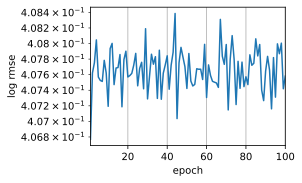

In [121]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)